In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mne

import glob
import os
import sys
from scipy.io import savemat, loadmat
from statsmodels.stats.multitest import fdrcorrection

sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import*

### TO DO: 

make this notebook handle the pre and post data at once without manually setting the period each time
also different musician levels

### Set up 

In [15]:
#-----------------------------
#           LOADING FILES AND INITIALIZING DIRECTORIES
#-----------------------------
#evoked_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_ERP_data'
#epochs_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data'

#use MIDI folders or audio folders to change triggers
evoked_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_ERP_data_MIDI'
epochs_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data_MIDI'


figs_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/figures'


#channels and times for plotting
ch_names_64, ch_names_72 = load_channels()
erp_times = load_erp_times()

good_listen_subjects, good_motor_subjects, musicians, nonmusicians = load_subject_lists()
subjects_to_process =   ['01', '04','05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '18', '19', '20', '21']
#subjects_to_process = ['14', '15']
#subjects_to_process = musicians
#subjects_to_process.remove('02')

#some promising differences when including just musicians (subjects 5,6,7)


In [16]:
def load_error_epochs_bysubject(subjects_to_process, epoch_type, sub_ave = True):
    """ 
    Loads the epochs for error trials
    subjects_to_process: list of subjects where each element is a string. e.g. ['01', '02']
    epoch_type: which error keystrokes are included. Currently 'all', 'inv', 'shinv' and 'norm'
        ---future: separate keystrokes that are the first keystroke after a map change from all the other keystrokes
    ---
    Returns a dataframe with columns 'subject', 'period', 'musician', and 'epoch_type'.
        each row of ['epochs'] is an array of shape n_channels x n_timepoints, and is the average of all epochs from one subject
    
    """

    epochs_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data'
    epochs_df = pd.DataFrame(columns = ['subject', 'period', 'musician', 'epochtype', 'epochs'])
    good_listen_subjects, good_motor_subjects, musicians, nonmusicians = load_subject_lists()

    assert isinstance (subjects_to_process, list)

    for subject in subjects_to_process:
        print('Processing subject: ', subject)

        if subject in musicians: 
            musician = 1
        else: 
            musician = 0
        for period in ['pre', 'post']:
            file_epochs_pre = glob.glob(os.path.join(epochs_dir, f'error_epochs_{epoch_type}_{period}_{subject}.fif'))[0]
            epochs_sub = mne.read_epochs(file_epochs_pre)

            if sub_ave:
                epochs_sub = np.mean(epochs_sub.get_data()[:, :64, :], axis = 0) #get only the eeg channels and average all trials per subject
            else: 
                #epochs_sub = epochs_sub.get_data()[:, :64, :]
                epochs_sub = epochs_sub.get_data()

            df_sub = pd.DataFrame({
                'subject': subject,
                'period' : period,
                'musician' : musician,
                'epochtype': epoch_type,
                'epochs': [epochs_sub]
            })
            epochs_df = pd.concat([epochs_df, df_sub])


    epochs_df.reset_index(drop=True, inplace=True)
    return (epochs_df)


In [17]:
epochs_df_all = load_error_epochs_bysubject(subjects_to_process, 'all')
epochs_df_inv = load_error_epochs_bysubject(subjects_to_process, 'inv')
epochs_df_shinv = load_error_epochs_bysubject(subjects_to_process, 'shinv')
epochs_df_norm = load_error_epochs_bysubject(subjects_to_process, 'norm')



epochs_df_firsts = load_error_epochs_bysubject(subjects_to_process, 'firsts', sub_ave=False)
epochs_df_others = load_error_epochs_bysubject(subjects_to_process, 'others', sub_ave=False)


Processing subject:  01
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_01.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
289 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_01.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
390 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  04
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_04.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices availa

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_01.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_01.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs

Processing subject:  06
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_06.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
369 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_06.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
386 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  07
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_07.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices availa

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_06.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_06.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs

Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_09.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
394 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_09.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
381 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  10
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_10.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_09.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_10.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs

Processing subject:  12
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_12.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
281 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_12.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
359 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  13
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_13.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices availa

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_12.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_12.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs

Not setting metadata
484 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  16
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_16.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
289 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_16.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
247 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  18
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_18.fif ...
    Foun

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_16.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_16.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs

Processing subject:  21
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_21.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
325 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_21.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
325 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  01
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_01.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices availa

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_21.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_21.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs

Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_post_05.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  06
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_06.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
186 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_post_06.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadat

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_post_05.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_06.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs

Not setting metadata
137 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_post_10.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  11
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_11.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
199 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_post_11.fif ...
    Found the data of interest:

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_post_10.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_11.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs

Processing subject:  14
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_14.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_post_14.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
174 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  15
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_15.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices availa

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_14.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_post_14.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs

Not setting metadata
169 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  19
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_19.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
190 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_post_19.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
212 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  20
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_20.fif ...
    Foun

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_19.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_post_19.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs

Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  04
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_pre_04.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_post_04.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  05
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_pre_05.fif ...
    F

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_pre_04.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_post_04.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_ep

0 projection items activated
Processing subject:  09
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_pre_09.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_post_09.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  10
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_pre_10.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_pre_09.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_post_09.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_ep

Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_post_14.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  15
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_pre_15.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_post_15.fif ...
    Found the data of inter

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_post_14.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_pre_15.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_ep

Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  01
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_pre_01.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_post_01.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  04
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_pre_04.fif ...
    Fou

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_pre_01.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_post_01.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epoc

Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_post_07.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  08
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_pre_08.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_post_08.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metada

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_post_07.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_pre_08.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epoc

        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  13
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_pre_13.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_post_13.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  14
Reading /Users/cindyzhang/Documents/M2/Audiomotor

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_pre_13.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_post_13.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epoc

Not setting metadata
109 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_post_19.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
111 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  20
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_pre_20.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_post_20.fif ...
    Found the data of interes

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_post_19.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_pre_20.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epoc

    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  05
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_pre_05.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_post_05.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  06
Reading /Users

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_pre_05.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_post_05.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_

Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  10
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_pre_10.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_post_10.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  11
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_pre_11.fif ...
  

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_pre_10.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_post_10.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_

96 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  14
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_pre_14.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_post_14.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  15
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_pre_15.fif ...
    Found the data of i

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_pre_14.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_post_14.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_

Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_post_18.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  19
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_pre_19.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_post_19.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting 

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_pre_19.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_firsts_post_19.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_

    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_post_04.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
311 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  05
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_pre_05.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_post_04.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_pre_05.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_

Not setting metadata
210 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  08
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_pre_08.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_post_08.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
227 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  09
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_pre_09.fif ...

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_pre_08.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_post_08.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_

Not setting metadata
184 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_post_10.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
155 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  11
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_pre_11.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
304 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_post_11.fif ...
    Found the data of 

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_post_10.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_pre_11.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_

Processing subject:  13
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_pre_13.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_post_13.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
229 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  14
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_pre_14.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matric

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_pre_13.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_post_13.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_

        0 CTF compensation matrices available
Not setting metadata
346 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_post_15.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
386 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  16
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_pre_16.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
190 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_post_15.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_pre_16.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_

Not setting metadata
257 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_post_20.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
329 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  21
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_pre_21.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
229 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_post_21.fif ...
    Found the data of 

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_post_20.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_others_pre_21.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_64607/291852897.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_

In [18]:
def subset_epochs(epochs_df, n_epochs):
    epochs_sub = np.mean([epoch[np.random.choice(epoch.shape[0], n_epochs, replace=True), :, :]
                                    for epoch in epochs_df['epochs']], axis = 1)
    epochs_df_new = epochs_df.copy()

    epochs_df_new['epochs'] = [epochs_sub[i] for i in range(epochs_df.shape[0])]

    return epochs_df_new
    

In [827]:
epochs_df_firsts_sub = subset_epochs(epochs_df_firsts, 99)
epochs_df_others_sub = subset_epochs(epochs_df_others, 99)

In [828]:
# ARRANGE EPOCHS INFO INTO A DICTIONARY

# Define dataset names and conditions
datasets = {
   # 'all': epochs_df_all,
   # 'inv': epochs_df_inv,
   # 'shinv': epochs_df_shinv,
   # 'norm': epochs_df_norm,
    'firsts': epochs_df_firsts_sub,
    'others': epochs_df_others_sub
}
periods = ['pre', 'post']
musician_status = {
    'mus': 'musician == 1',
    'nmus': 'musician == 0'
}

# Initialize dictionary
epochs_dict = {}

# Loop through datasets, periods, and musician status
for dataset_name, dataset in datasets.items():
    for period in periods:
        for mus, condition in musician_status.items():
            key = f'{dataset_name}_{period}_{mus}'
            query_str = f"period == '{period}' and {condition}"
            epochs_dict[key] = np.array(dataset.query(query_str)['epochs'].tolist())


### Comparing ERPs

In [829]:
#take subset of epochs_others
epochs_df_firsts.shape

(36, 5)

In [830]:
#testing specific channels 
p_channels = ['Cz', 'FCz']
p_ch_idx = ch_index(p_channels)
ch_totest = p_channels


compare_1 = np.array(epochs_df_firsts_sub.query("period == 'pre' ")['epochs'].tolist())
compare_2 = np.array(epochs_df_others_sub.query("period == 'pre'")['epochs'].tolist())
diff_evoked_sa = find_diff_sa(compare_1, compare_2)



to_compare = [compare_1, compare_2]




In [835]:
diff_evoked_sa.shape

(18, 64, 91)

In [836]:
ch_totest

['Cz', 'FCz']

In [831]:
#calculate p-value over time

#p_values = p_times(to_compare, channels = ch_totest) #independent t-test

#1-sample t-test on difference pre vs post

p_within = p_times_1sample(diff_evoked_sa, channels = ch_totest, tmin = 0.05, tmax = 0.2)


Calculating p-value over ['Cz', 'FCz']
Distribution is not normal. p =  0.00010985010059414936


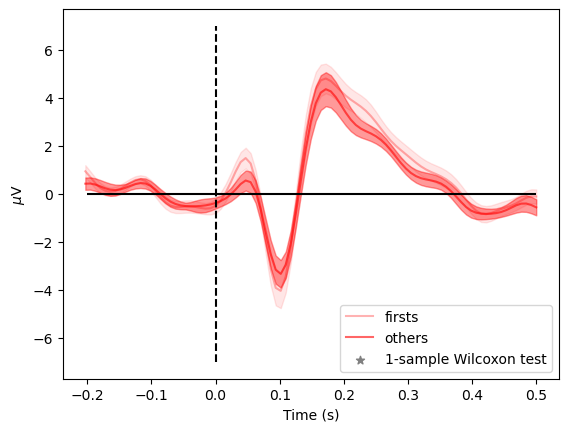

In [832]:
######################
# COMPARISON FIGURE
######################
plot_labels = ['firsts', 'others']
groupcolor = 'red'

plt.figure()
shade = 0.3 #change in shade between the two lines

for i, data in enumerate(to_compare):
    

    if ch_totest == 'all':
        plt.title(f'Error ERP averaged over all channels')
        mean_data = data.mean(axis=0)[0:64].mean(axis = 0)
        sem_data = data.std(axis=0)[0:64].mean(axis = 0) / np.sqrt(data.shape[0])

    elif ch_totest == p_channels:

        plt.title(f'Error ERP averaged over {p_channels} channels')
        mean_data = data.mean(axis=0)[p_ch_idx].mean(axis = 0)
        sem_data = data.std(axis=0)[p_ch_idx].mean(axis = 0) / np.sqrt(data.shape[0])
    


    #rescale data
    mean_data = np.array([x * 1000000 for x in mean_data])
    sem_data = np.array([x * 1000000 for x in sem_data])

    plt.plot(erp_times, mean_data, label=plot_labels[i], color = groupcolor, alpha = shade)
    plt.fill_between(erp_times, mean_data - sem_data, mean_data + sem_data, color = groupcolor, alpha=shade-0.2)
    shade += 0.3



#############################
#plot significant points
###############################
#find timepoints where ERP is significantly different
#sig_idx_ind = [index for index, item in enumerate(p_values) if item < 0.05]
sig_idx_within = [index for index, item in enumerate(p_within) if item < 0.05]

#get y values
max_y = np.max(to_compare)  
#y_ind = [7.5]*len(sig_idx_ind)
y_within = [7]*len(sig_idx_within)
plt.scatter(erp_times[sig_idx_within], y_within, marker="*", color='grey', label = '1-sample Wilcoxon test')
#plt.scatter(erp_times[sig_idx_ind], y_ind, marker="*", color='rosybrown', label = 'independent t-test')


#aesthetics
plt.title('')
plt.hlines(0, -0.2, 0.5, color = 'black')
plt.vlines(0, -7, 7, color = 'black', linestyles= '--')
plt.ylabel('$\mu$V')
plt.xlabel('Time (s)')
#plt.ylim(-6,6)
plt.legend(loc = 'lower right')

#plt.savefig(figs_dir+f'/ERP_{task}_{participants}.svg')

### Comparing channel topographies

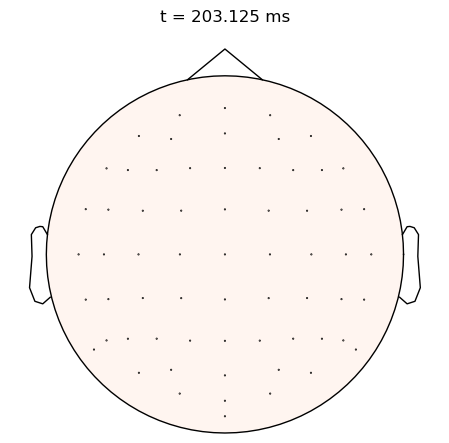

In [833]:
ep_info = load_ep_info() #mne info for positions

#choosing times where there are significant differences
timepoint  = 0.2 #in seconds
time_idx = time_index([timepoint])[0] #converts the time in seconds to the closest available timepoint in ERP array, then gets the index of that timepoint

#calculating p values over channels
p_values_ch = p_chs(to_compare, time_idx, ttest = 'ind')

#scaling p values by 1-p so that smaller p values are more red, and p>0.05 is replaced with 0
p_values_ch_scaled = scale_p_channels(p_values_ch)


fig, axes = plt.subplots()  # Use plt.subplots() to create a figure and axes
axes.set_title(f't = {erp_times[time_idx]*1000} ms')
im, cn = mne.viz.plot_topomap(p_values_ch_scaled, pos=ep_info, size=1, axes=axes, vlim = (0.95,1))  # Pass the axes object to the plot_topomap function



### Export epoch data

In [834]:
"""musicians_pre = np.mean(epochs_df_all.query("period == 'pre' and musician == 1")['epochs'], axis=0)
musicians_post = np.mean(epochs_df_all.query("period == 'post' and musician == 1")['epochs'], axis=0)
nonmusicians_pre = np.mean(epochs_df_all.query("period == 'pre' and musician == 0")['epochs'], axis=0)
nonmusicians_post = np.mean(epochs_df_all.query("period == 'post' and musician == 0")['epochs'], axis=0)

savemat('playing_epochs.mat',{
    'mus_pre': musicians_pre,
    'mus_post': musicians_post,
    'nmus_pre': nonmusicians_pre,
    'nmus_post': nonmusicians_post,
    'fs':128,
    'erp_times': erp_times

})"""

'musicians_pre = np.mean(epochs_df_all.query("period == \'pre\' and musician == 1")[\'epochs\'], axis=0)\nmusicians_post = np.mean(epochs_df_all.query("period == \'post\' and musician == 1")[\'epochs\'], axis=0)\nnonmusicians_pre = np.mean(epochs_df_all.query("period == \'pre\' and musician == 0")[\'epochs\'], axis=0)\nnonmusicians_post = np.mean(epochs_df_all.query("period == \'post\' and musician == 0")[\'epochs\'], axis=0)\n\nsavemat(\'playing_epochs.mat\',{\n    \'mus_pre\': musicians_pre,\n    \'mus_post\': musicians_post,\n    \'nmus_pre\': nonmusicians_pre,\n    \'nmus_post\': nonmusicians_post,\n    \'fs\':128,\n    \'erp_times\': erp_times\n\n})'